In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import random
from transformers import (
    BertTokenizer,
    BertModel,
    BertConfig,
)
import argparse
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics


In [2]:
import io
import ast
def get(path):
    chin = []
    ref = []
    trans = []
    score = []
    lab = []
    with io.open(path,'r',encoding='utf8') as f:
        counter = 0
        for line in f:
            x = counter % 6


            if x == 0:
                line = line[:-2]
                chin.append(line)
            if x == 1:
                line = line[:-2]
                ref.append(line)
            if x == 2:
                line = line[:-2]
                trans.append(line)
            if x == 3:
                score.append(ast.literal_eval(line))
            if x == 4:

                if line.strip() == "H":
                    lab.append(1)
                if line.strip() == "M":
                    lab.append(0)
            counter = counter + 1
    return chin, ref, trans, score, lab 


In [3]:
chin, ref, trans, score, lab = get("train.txt")

In [4]:
chinT, refT, transT, scoreT, labT = get("test.txt")

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset,SubsetRandomSampler
from tqdm import tqdm, trange
import pandas as pd
import io
import json
import os
import numpy as np
import random
from transformers import (
    BertTokenizer,
   
    BertModel,
    #AutoTokenizer,
    #AutoModelForQuestionAnswering
)

import numpy as np
from torchtext import data
import pandas as pd
import re
import argparse
from collections import Counter

from sklearn.linear_model import LogisticRegression
import requests
import torch.nn as nn
import torch.optim as optim

class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens):
        _, pooled_output = self.bert(tokens,return_dict=False)
        linear_output = self.linear3(self.linear2(self.linear1(pooled_output)))
        proba = self.sigmoid(linear_output)
        return proba
    
def most_frequent(List): 
    counter = 0
    num = List[0]  
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
    return num



In [6]:
def process_data(text, ref):
    """
    Adds CLS, and SEP tokens to input text
    """
    input_text = []
    for i in range(len(text)):
            input_text.append( "[CLS] " + text[i] + " [SEP] " + ref[i] + " [SEP]")
    return input_text

def get_data(trans, lab, ref, is_train = True):
    is_impossible = lab
    input_text = process_data(trans, ref)
    
    print(len(input_text))
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    print("working")
    input_ids = []
    max_len = 0
    for text in input_text:
        input_id = tokenizer.encode(text)
        input_ids.append(input_id)
        if len(input_id) > max_len:
            max_len = len(input_id)

    padded = np.array([i + [0]*(max_len - len(i)) for i in input_ids])
    attention_mask = np.where(padded != 0, 1, 0)
    input_ids = torch.tensor(padded)
    print(input_ids.size)
    attention_mask = torch.tensor(attention_mask)
    print(attention_mask.size)
    if is_train:
        train_tokens_tensor = input_ids[:int(0.8*len(input_ids))]
        train_y_tensor = torch.tensor(is_impossible[:int(0.8*len(input_ids))]).float().reshape(-1,1)
        test_tokens_tensor = input_ids[int(0.8*len(input_ids)):]
        test_y_tensor = torch.tensor(is_impossible[int(0.8*len(input_ids)):]).float().reshape(-1,1)
        return train_tokens_tensor, train_y_tensor, test_tokens_tensor, test_y_tensor
    else:
        return input_ids, torch.tensor(is_impossible).float().reshape(-1,1)

In [7]:
train_tokens_tensor,train_y_tensor, test_tokens_tensor, test_y_tensor = get_data(trans, lab, ref)

584
working
<built-in method size of Tensor object at 0x7fd37ef34780>
<built-in method size of Tensor object at 0x7fd37f09a700>


In [93]:
from transformers import AdamW

model = BertBinaryClassifier()
model = model.cuda()


# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer2 = AdamW(optimizer_grouped_parameters, lr=5e-6)

In [94]:
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer2 = AdamW(optimizer_grouped_parameters, lr=5e-6)

Training model...
0.03297019849220912
0.03172349433104197
0.031041782846053443
0.030792905886967977
0.03150853142142296
Training Completed


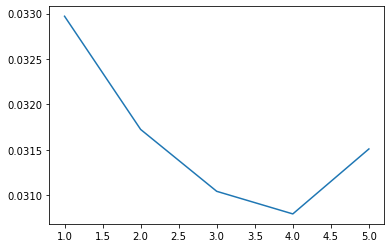

In [100]:
training(5, train_dataloader, optimizer2, model)

In [99]:
optimizer2.param_groups[0]['lr'] = 1e-7

In [16]:
percentage = 0.8
EPOCHS = 15
BATCH_SIZE = 32

#create train and val data set
train_y_tensor = torch.tensor(train_y_tensor).float().reshape(-1,1)
test_y_tensor = torch.tensor(test_y_tensor).float().reshape(-1,1)
train_dataset = TensorDataset(train_tokens_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataset = TensorDataset(test_tokens_tensor, test_y_tensor)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)




<ipython-input-16-0728753e1e67>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y_tensor).float().reshape(-1,1)
<ipython-input-16-0728753e1e67>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_tensor = torch.tensor(test_y_tensor).float().reshape(-1,1)


In [10]:
bert_clf = BertBinaryClassifier()
#bert_clf = model
#bert_clf.load_state_dict(torch.load("model2.pt"))

bert_clf = bert_clf.cuda()
optimizer = optim.Adam(bert_clf.parameters(), lr=5e-6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [95]:
def training(EPOCHS,train_dataloader, optimizer, bert_clf):
    bert_clf.train()
    print('Training model...')
    loss_vals=[]
    for epoch_num in range(EPOCHS):
        epoch_loss= []
        for step_num, batch_data in enumerate(train_dataloader):
            token_ids, labels = tuple(t.to(device) for t in batch_data)
            probas = bert_clf(token_ids)
            loss_func = nn.BCELoss()
            batch_loss = loss_func(probas, labels)

            bert_clf.zero_grad()
            batch_loss.backward()
            epoch_loss.append(batch_loss.item())
            optimizer.step()

                # rest of the code
            # rest of the code
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(sum(epoch_loss)/len(epoch_loss))
    print('Training Completed')
    my_plot(np.linspace(1, EPOCHS, EPOCHS).astype(int), loss_vals)

In [29]:
optimizer.param_groups[0]['lr'] = 1e-7

Training model...
0.029352575043837228
0.03313051201403141
0.029699536661307018
0.028845060989260672
0.028632429117957752
Training Completed


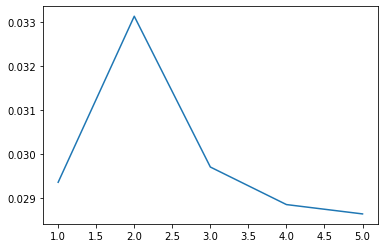

In [30]:
training(5, train_dataloader, optimizer, bert_clf)

In [31]:
torch.save({
            'epoch': 25,
            'model_state_dict': bert_clf.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0.91623744}, "model2.pt")


In [101]:
#validation
def evaluation(dataloader, length, bert_clf):
    with torch.no_grad():

        loss_fn = nn.BCELoss()
        bert_clf.eval()
        print('Evaluating model...')
        correct = 0
        #l1 = np.array([])
        #l2 = np.array([])
        loss_vals=  []
        total = []
        correct_num = []
        label = []
        pred = []
        for batch_index, batch_data in enumerate(dataloader):
            input_t, y = tuple(t.to(device) for t in batch_data)
            preds = bert_clf(input_t)
            p = preds.cpu().data.reshape(-1).detach().numpy().round()
            y1 = y.cpu().data.reshape(-1).detach().numpy()


            for i in range(len(p)):
                if p[i] == y1[i]:
                    correct = correct + 1  

            loss = loss_fn(preds, y)
            loss_vals.append(loss.item())
            label.append(y1)
            pred.append(p)

            if(batch_index > 0 and batch_index/10 == 0):
                total.append(sum(loss_vals)/len(loss_vals))
                correct_num.append(correct/batch_index*32)
                print(f"Loss: {loss.detach()}")

        print("Accuracy={}".format(correct/length))
        return label, pred

In [33]:
label, pred = evaluation(val_dataloader, 0.2*len(trans), bert_clf)

Evaluating model...
Accuracy=0.9160958904109588


In [102]:
label2, pred2 = evaluation(val_dataloader, 0.2*len(trans), model)

Evaluating model...
Accuracy=0.9075342465753424


Evaluating model...
Accuracy=0.9540229885057471
precision: 0.92
recall: 1.0
f1: 0.9583333333333334


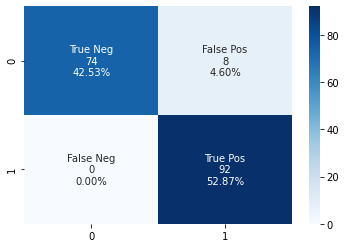

In [107]:
label2, pred2 = evaluation(test_dataloader, len(tlogLab), model)
pred2, label2 = get_p_l(pred2, label2)
get_evaluation_result(pred2, label2)

precision: 0.8548387096774194
recall: 0.9636363636363636
f1: 0.905982905982906


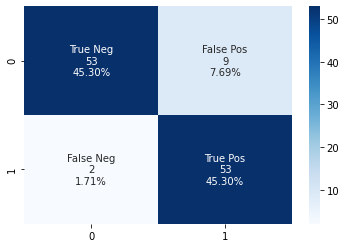

In [103]:
pred2, label2 = get_p_l(pred2, label2)
get_evaluation_result(pred2, label2)

In [37]:
from sklearn.metrics import confusion_matrix,precision_score, f1_score, recall_score
import seaborn as sns

In [61]:
#print precision, recall, f1 score
def get_p_l(pred, label):
    prediction = []
    expect = []
    for p in pred:
        for x in p:
            prediction.append(x)
    for l in label:
        for x in l:
            expect.append(x)
    return prediction, expect
            
def get_evaluation_result(prediction, expect):
    print("precision: "+ str(precision_score(expect, prediction)))
    print("recall: "+ str(recall_score(expect, prediction)))
    print("f1: "+ str(f1_score(expect, prediction)))
    cf_matrix = confusion_matrix(expect, prediction)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    

In [49]:
#test 
token_test, label_test = get_data(transT, labT, refT, False)
test_dataset = TensorDataset(token_test, label_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

l, p = evaluation(test_dataloader, len(label_test)， bert_clf)

174
working
<built-in method size of Tensor object at 0x7fd35e4cf640>
<built-in method size of Tensor object at 0x7fd35ea6d4c0>
Evaluating model...
Accuracy=0.9597701149425287


precision: 0.8688524590163934
recall: 0.9636363636363636
f1: 0.9137931034482758


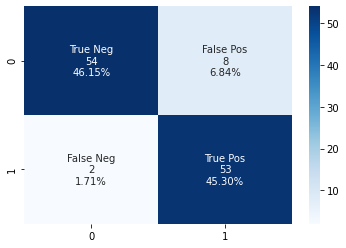

In [47]:
pred, label = get_p_l(pred, label)
get_evaluation_result(pred, label)

precision: 0.9292929292929293
recall: 1.0
f1: 0.9633507853403142


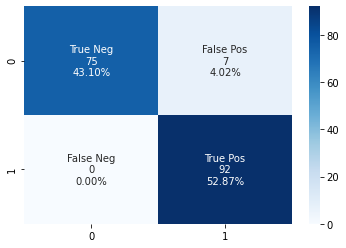

In [53]:
p, l = get_p_l(p, l)
get_evaluation_result(p, l)

In [64]:
#baseline model: logistic regression

def get_cls_from_input(input_text,  is_impossible, emb_type = 0):
    """
    Function that returns CLS embeddings for each entry in input_text
    """
    #BERT model and tokenizer     
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    input_ids = [] #holds all the token id encodings for each input
    features = np.zeros((len(input_text), 768))
    max_len = 0
    for text in input_text:
        input_id = tokenizer.encode(text)
        input_ids.append(input_id)
        if len(input_id) > max_len:
            max_len = len(input_id)

    is_impossible.append(max_len)
    is_impossible = np.array(is_impossible)

    with torch.no_grad():
        for i in range(len(input_ids)):
            input = input_ids[i]
            padded = np.array(input + [0]*(max_len - len(input)))
            attention_mask = np.where(padded != 0, 1, 0)
            input = torch.tensor([padded]).type(torch.LongTensor)
            attention_mask = torch.tensor([attention_mask])
            last_hidden_states = model(input, attention_mask = attention_mask)

            if (emb_type == 0): #cls token
                features[i] = (last_hidden_states[0][:,0,:].numpy())

            elif(emb_type == 1): #avg of work tokens
                token_vecs = last_hidden_states[0][0]
                features[i] = torch.mean(token_vecs, dim=0)


    return features, is_impossible

def get_data2(trans, lab, ref, csv_name_input, csv_name_labels, emb_type = 0 ):
    is_impossible = lab
    input_text = process_data(trans, ref)
    
    if os.path.exists(csv_name_input) and os.path.exists(csv_name_labels):
        print("Found Training Set Locally")
        labels = np.load(csv_name_labels)
        inputs = np.load(csv_name_input)
        max_len = labels[-1]
        labels = labels[:-1]
       
    else:
        inputs, labels = get_cls_from_input(input_text, is_impossible, emb_type)
        max_len = labels[-1]
        labels = labels[:-1]

    return inputs, labels, input_text, max_len


In [54]:
logFea, logLab, input_text, max_len = get_data2(trans, lab, ref, "bert.csv", "lab_bert.csv")

In [74]:
from sklearn.linear_model import LogisticRegression
def logisticReg(inputs, labels):
    """Returns the best performing logistic regression model. 
    Function that trains a logistic regression classification model on given training data 
    and then evaluated it on given test data. 
    """
    #establishing ranges for parameters
    perf = 0
    best_c = .001
    best_log = LogisticRegression(C=1)
    c_param_range = [0.001,0.01,0.1,1,10,100]
    for i in c_param_range:
        log_model = LogisticRegression(C=i)
        log_model.fit(inputs,labels)
        #evaluate
        y = log_model.predict(inputs)
        #implement confusion matrix + other metrics
        score = log_model.score(inputs, labels)
        if (perf < score):
            best_c = i
            perf = score 
            best_log = log_model
    print("Best C: ", best_c, " Score: ", perf)   
    train_preds = best_log.predict(inputs)
    get_evaluation_result(train_preds, labels)
    return best_log
    


/home/cf348/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cf348/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Best C:  1  Score:  1.0
precision: 1.0
recall: 1.0
f1: 1.0


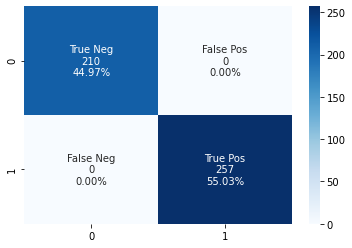

In [78]:
#logistic regression
X_train= logFea[:int(0.8*len(logFea))]
y_train= logLab[:int(0.8*len(logFea))]
log_model = logisticReg(X_train,y_train)


precision: 0.7936507936507936
recall: 0.9090909090909091
f1: 0.847457627118644


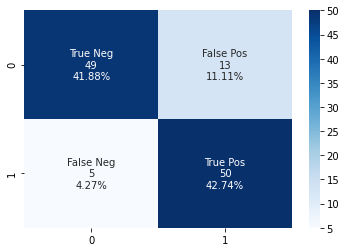

In [83]:
#evaluate logreg
X_test = logFea[int(0.8*len(logFea)):]
y_test = logLab[int(0.8*len(logFea)):-1]

test_preds = log_model.predict(X_test)
get_evaluation_result(test_preds, y_test)


In [80]:
#baseline-svm
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.01, gamma=1, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] .

[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] .

[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .

[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   28.7s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [81]:
print(grid.best_estimator_)

SVC(C=0.01, gamma=1, kernel='poly')


In [84]:
grid_predictions = grid.predict(X_test)

precision: 0.7903225806451613
recall: 0.8909090909090909
f1: 0.8376068376068375


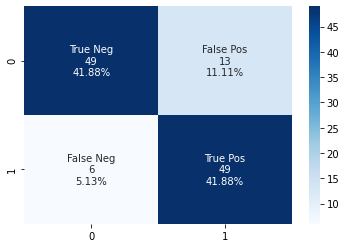

In [85]:
#svm-eval
get_evaluation_result(grid_predictions, y_test)

precision: 1.0
recall: 1.0
f1: 1.0


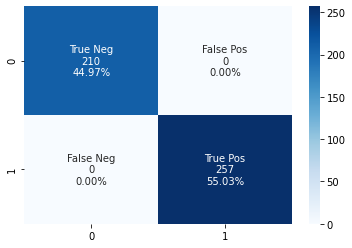

In [89]:
#svm-train
get_evaluation_result(grid.predict(X_train), y_train)

In [86]:
tlogFea, tlogLab, input_text, max_len = get_data2(transT, labT, refT, "bertT.csv", "lab_bertT.csv")

precision: 0.7980769230769231
recall: 0.9021739130434783
f1: 0.8469387755102041


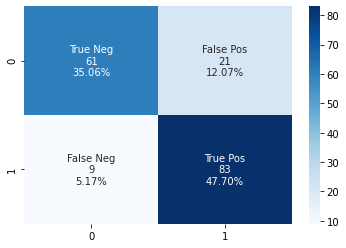

In [90]:
get_evaluation_result(grid.predict(tlogFea), tlogLab)

precision: 0.7884615384615384
recall: 0.8913043478260869
f1: 0.836734693877551


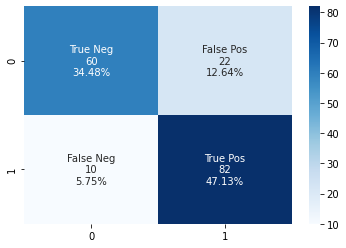

In [91]:
get_evaluation_result(log_model.predict(tlogFea), tlogLab)